In [1]:
#!jupyter nbconvert --to=python NPP_TotalGlobal_python3.ipynb

[NbConvertApp] Converting notebook NPP_TotalGlobal_python3.ipynb to python
[NbConvertApp] Writing 11544 bytes to NPP_TotalGlobal_python3.py


In [42]:
class NPP_TotalGlobal:
    '''
    class NPP_TotalGlobal(runname,resultpath,savepath,meshpath,first_year,last_year,
                 mapproj='pc',savefig=False,layerwise=False)
    '''
    def __init__(self,runname,resultpath,savepath,meshpath,first_year,last_year,
                 mapproj='pc',
                 savefig=False,
                 layerwise=False,depth_array=[]):

        self.runname = runname
        self.resultpath = resultpath
        self.savepath = savepath
        self.meshpath = meshpath
        self.fyear = first_year
        self.lyear = last_year
        self.mapproj = mapproj
        self.savefig = savefig
        self.layerwise = layerwise
        self.depth_array = depth_array

        import matplotlib.pyplot as plt
        import numpy as np
        from netCDF4 import Dataset
        from scipy.interpolate import griddata
        import skill_metrics as sm
        import cartopy.crs as ccrs
        #import pickle

        import pyfesom2 as pf


        # load FESOM mesh -------------------------------------------------------------------------------------
        mesh       = pf.load_mesh(meshpath)
        years = range(self.fyear, self.lyear+1)
        
        
        # load nodal area -------------------------------------------------------------------------------------
        f = Dataset(self.resultpath + '/' + self.runname + '.mesh.diag.nc', 'r')
        nod_area = f.variables['nod_area'][:] # Moritz
        #nod_area_surface = nod_area[0,:]
        
        #NodalArea2D = f.variables['nod_area'][:,:]-1 # Ozgur 
        #????????????? wieso hier -1 ?????????
        
        # get depth of export production
        i_ep_depth = 10
        nod_depth = f.variables['zbar'][:]
        ep_depth = nod_depth[i_ep_depth]
        print('Calculating EP at depth = {0} m'.format(ep_depth))

        
        #print('shape nod_area: {0}\nshape nod_area_surface: {1}'.format(np.shape(nod_area),np.shape(nod_area_surface)))
        
        ## same as original code?? -->
        #f           = Dataset(self.ncfileNPPTotalGlobal, 'r')
        #NodalArea2D = f.variables['cluster_area'][:]
        #f           = Dataset(self.meshpath+'/griddes.nc', 'r')
        #cell_area = f.variables['cell_area'][:]
        
        # ?????????? what was done here in FESOM1.4 ??????????????
        #depths = np.unique(mesh.z3)
        #ep_ind = np.nonzero((depths == 100))
        #ep_ind = np.squeeze(mesh.n32[:,ep_ind])
        #ep_surf= np.squeeze(np.nonzero((ep_ind>-999)))
        #ep_ind = np.delete(ep_ind,np.nonzero((ep_ind==-999))) # Only real indexes are kept
        
        
        # calculating total NPP per year -------------------------------------------------------------------------------
        NPPtotal = np.zeros(len(years))
        DiaTotal  = np.zeros(len(years))
        NanoTotal = np.zeros(len(years))
        EPtotal   = np.zeros(len(years))
        
        for i in range(len(years)):
            ind_year = years[i]
            print('loading {0}'.format(ind_year))
            
            NPPn = pf.get_data(resultpath, "NPPn", ind_year, mesh, how="mean", compute=True, runid=self.runname, silent=True)
            NPPd = pf.get_data(resultpath, "NPPd", ind_year, mesh, how="mean", compute=True, runid=self.runname, silent=True)
            ## NPPn:units = "mmolC/(m2*d)"
                
            NPPtotal_aux       = (NPPd+NPPn)*12.01
            NPPtotal_aux       = 365 * NPPtotal_aux    # Conversion from [mg/m2/day]   => [mg/m2/yr]
            #print('shape NPPtotal: {0}'.format(np.shape(NPPtotal_aux)))
            
            NPPtotal[i] = np.sum(NPPtotal_aux*nod_area_surface)/1e18  # summing up and converting to [Pg C/year]
        
            NanoTotal[i] = np.sum(12.01*365.*NPPn*nod_area_surface)/1e18 
            DiaTotal[i]  = np.sum(12.01*365.*NPPd*nod_area_surface)/1e18
            
            # Ozgur's results have different var_ID for DetC:
            DetC = pf.get_data(resultpath, "tra_012", ind_year, mesh, how="mean", compute=True, runid=self.runname, silent=True)
            #DetC = pf.get_data(resultpath, "DetC", ind_year, mesh, how="mean", compute=True, runid=self.runname, silent=True)
            Vdet = 0.0288 * 100. + 20. ## what's this?
            DetC = 365. * DetC * 12.01 * Vdet # [mmol/m3] => [mg/m2/yr]
            detct=DetC[:,i_ep_depth]
            #EPtotal[i] = np.sum(detct*NodalArea2D[10,:])/1e18 # that's Ozgur's use of nodal area
            EPtotal[i] = np.sum(detct * nod_area[i_ep_depth,:])/1e18
            
            
        
        # plotting total NPP -------------------------------------------------------------------------------        
        fig = plt.figure(figsize=(12,8), facecolor='w', edgecolor='k', tight_layout = True)
        plt.subplot(2, 3, 1)
        plt.plot(years,NPPtotal,'.-',label='Total')
        #plt.plot(years,NanoTotal,'.-g',label='Nano')
        #plt.plot(years,DiaTotal,'.-r',label='Dia')
        plt.title(self.runname+': Global NPP')
        plt.ylabel(r'[Pg C yr$^{-1}$]')
        plt.legend(loc='upper right')
        
        plt.subplot(2, 3, 2)
        #plt.plot(years,NPPtotal,'.-',label='Total')
        plt.plot(years,NanoTotal,'.-g',label='Nano')
        #plt.plot(years,DiaTotal,'.-r',label='Dia')
        #plt.title(self.runname+': Global NPP')
        #plt.ylabel(r'[Pg C yr$^{-1}$]')
        plt.legend(loc='upper right')
        
        plt.subplot(2, 3, 3)
        #plt.plot(years,NPPtotal,'.-',label='Total')
        #plt.plot(years,NanoTotal,'.-g',label='Nano')
        plt.plot(years,DiaTotal,'.-r',label='Dia')
        #plt.title(self.runname+': Global NPP')
        #plt.ylabel(r'[Pg C yr$^{-1}$]')
        plt.legend(loc='upper right')
        
        # all NPP together
        plt.subplot(2, 3, 4)
        plt.plot(years,NPPtotal,'.',label='Total')
        plt.plot(years,NanoTotal,'.g',label='Nano')
        plt.plot(years,DiaTotal,'.r',label='Dia')
        plt.title(self.runname+': Global NPP')
        plt.ylabel(r'[Pg C yr$^{-1}$]')
        plt.legend(loc='upper right')

        # Export production
        plt.subplot(2, 3, 5)
        plt.plot(years,EPtotal,'.')
        plt.title('{0}: Global EP at {1} m'.format(self.runname, ep_depth))
        plt.ylabel(r'[Pg C yr$^{-1}$]')
        

        if(savefig):
            plt.savefig(self.savepath+self.runname+'_'+'NPP_TotalGlobal_'+str(self.fyear)+'to'+str(self.lyear)+'.png', dpi = 300, bbox_inches='tight')
        plt.show(block=False)

Calculating EP at depth = -90.0 m
loading 1949
loading 1950
loading 1951
loading 1952
loading 1953
loading 1954
loading 1955
loading 1956
loading 1957
loading 1958
loading 1959
loading 1960
loading 1961
loading 1962
loading 1963
loading 1964
loading 1965
loading 1966
loading 1967
loading 1968
loading 1969
loading 1970
loading 1971
loading 1972
loading 1973
loading 1974
loading 1975
loading 1976
loading 1977
loading 1978


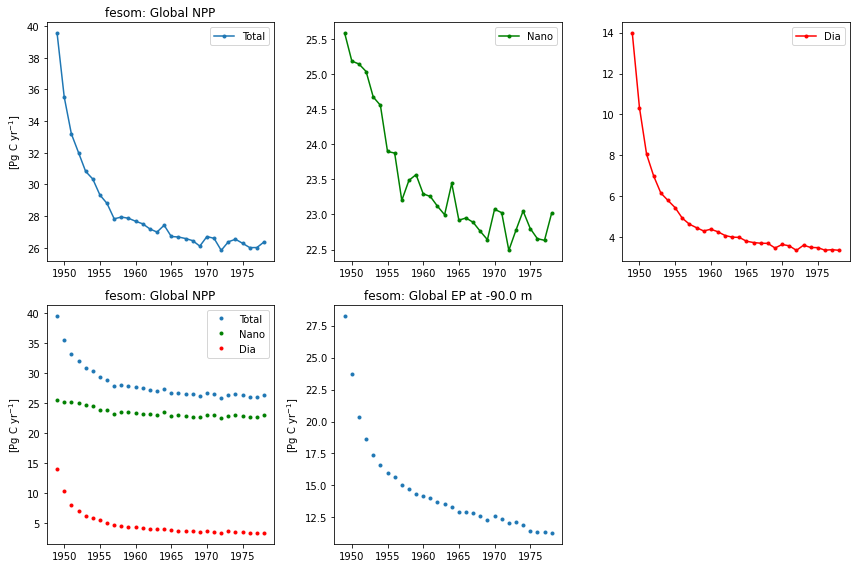

In [45]:
### TESTING ###
if __name__ == "__main__":
    import pyfesom2 as pf
    import numpy as np
    
    # run specification -------------------------------------------------------------------------------------
    #runid      =  'mo1'
    #resultpath = '/work/ollie/mozeisin/results/f2r1.2/' + runid
    #first_year, last_year = 1948, 1950
    
    runid = 'fesom'
    resultpath ='/work/ollie/ogurses/output_f2r2/SECOND_RUN/'
    first_year = 1949
    last_year  = 1978

    savepath = '/home/ollie/mozeisin/evaluation/mo_files/'

    htmlname     =  runid + '_TEST_NPP_TotalGlobal.html'
    htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'

    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

    #modulepath = '/home/ollie/mozeisin/py_recom/GlobalAssessment'
    #modulepath   = '/home/ollie/jhauck/py_fesom/modules/'

    #obspath      = '/home/ollie/mseifert/py_fesom/CreateRunFiles/Initialization/Output/'

    # WOA ------------------------------------------------------------------------------------    
#    ncpath = ncfileDIC
    #!ncdump -h $ncpath
    
    # now test:runname,resultpath,savepath,meshpath,first_year,last_year
    test = NPP_TotalGlobal(runid,resultpath,savepath,meshpath,first_year,last_year,layerwise=False,savefig=False)

In [46]:
## check differences between Moritz' and Ozgur's nodal area calculation
if(__name__ == '__main__'):
    import matplotlib.pyplot as plt
    import numpy as np
    from netCDF4 import Dataset
    from scipy.interpolate import griddata
    import skill_metrics as sm
    import cartopy.crs as ccrs
    #import pickle

    import pyfesom2 as pf

    runid      =  'mo1'
    resultpath = '/work/ollie/mozeisin/results/f2r1.2/' + runid

    f = Dataset(resultpath + '/' + runid + '.mesh.diag.nc', 'r')
    nod_area = f.variables['nod_area'][:] # Moritz
    nod_area_surface = nod_area[0,:]
    print(np.shape(nod_area))

    NodalArea2D = f.variables['nod_area'][:,:]-1 # Ozgur
    print(np.shape(NodalArea2D))

    print(nod_area - NodalArea2D)
    # again: why -1??

    # get depth of export production
    nod_depth = f.variables['zbar'][:]
    print(nod_depth[10])

(48, 126858)
(48, 126858)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
-90.0


In [47]:
## overview nc files
if(__name__ == '__main__'):
    !ncdump -h '/work/ollie/mozeisin/results/f2r1.2/mo1/mo1.mesh.diag.nc'
    !ncdump -h '/work/ollie/mozeisin/results/f2r1.2/mo1/NPPn.mo1.1948.nc'
    

netcdf mo1.mesh.diag {
dimensions:
	nod_n = 126858 ;
	edg_n = 371644 ;
	elem_n = 244659 ;
	nl = 48 ;
	nl1 = 47 ;
	n2 = 2 ;
	n3 = 3 ;
	n4 = 4 ;
	N = 9 ;
variables:
	double zbar(nl) ;
		zbar:long_name = "depth of levels" ;
	double Z(nl1) ;
		Z:long_name = "depth of layers" ;
	double elem_area(elem_n) ;
		elem_area:long_name = "element areas" ;
	int nlevels_nod2D(nod_n) ;
		nlevels_nod2D:long_name = "number of levels below nodes" ;
	int nlevels(elem_n) ;
		nlevels:long_name = "number of levels below elements" ;
	int nod_in_elem2D_num(nod_n) ;
		nod_in_elem2D_num:long_name = "number of elements containing the node" ;
	int nod_part(nod_n) ;
		nod_part:long_name = "nodal partitioning at the cold start" ;
	int elem_part(elem_n) ;
		elem_part:long_name = "element partitioning at the cold start" ;
	double zbar_e_bottom(elem_n) ;
		zbar_e_bottom:long_name = "element bottom depth" ;
	double zbar_n_bottom(nod_n) ;
		zbar_n_bottom:long_name = "nodal bottom depth" ;
	double nod_area(nl, nod_n) ;
		n

## export to html

In [50]:
if(__name__ == '__main__'):
    %autosave 2
    import time
    time.sleep(15)
    
    !jupyter nbconvert NPP_TotalGlobal_python3.ipynb --output-dir=$htmlpath --output $htmlname --to html 

Autosaving every 2 seconds
[NbConvertApp] Converting notebook NPP_TotalGlobal_python3.ipynb to html
[NbConvertApp] Writing 377813 bytes to /home/ollie/mozeisin/evaluation/mo_files/html/fesomTEST_NPP_TotalGlobal.html
